In [1]:
import numpy as np
import scipy as sp
import scipy.integrate as spint

import matplotlib.pyplot as plt
import pdb

In [2]:
class SolutionBranch():
    
    def __init__(self, sol, stage):
        if type(sol) is list:
            self.sols = sol
            self.stages = stage
        else:
            self.sols = [sol]
            self.stages = [stage]
        self.DOF = self.sols[0].y.shape[0] # get size of the state
        
    def sol(self, time):
        
        time = np.asarray(time)
        if time.ndim == 0:
            return self._sol(time)
        
        ys = [self._sol(t) for t in time]
        
        return np.transpose(np.vstack(ys))
    
    def _sol(self, time):
        """Get the solution at some time in this branch. If there are multiple stages, checks the last one first and works backwards"""
        
        # each solution segment has a t min and a t max
        for sol in reversed(self.sols):
            #checks from the back!
            if time >= sol.sol.t_min and time <= sol.sol.t_max:
                return sol.sol(time)
        # if it doesnt fall into any of the ranges, return the error
        error = [np.nan,]*self.DOF
        if error is None:
            raise ValueError("Requested time is not in the solved times")
            
        return error
    
    def t_min(self):
        return min(sol.sol.t_min for sol in self.sols)
    
    def t_max(self):
        return max(sol.sol.t_max for sol in self.sols)
            
    
    
    def __add__(self, other):
        """Add a second branch"""
        
        if self.DOF != other.DOF:
            raise RuntimeError("Adding SolutionBranches requires them to have the same state vector size")
        
        stages = self.stages + other.stages
        sols = self.sols + other.sols
        
        newBranch = SolutionBranch(sols, stages)

        return newBranch
        
    def __repr__(self):
        return f'\n [\n Stages: {self.stages}\n Sols: {self.sols} \n ]\n '
    

In [52]:
class VerySimpleRocket():
    
    def __init__(self):
        self.m = 40
        self.T = 4000
        self.g = 9.81
        self.y0 = np.array([0., 0.])
        self.rhoCDA1 = 0.05
        self.rhoCDA2 = 0.1
        
        self.stage_list = [0,1,2]
        self.staging_functions = [self.staging_deploy_drogue,self.staging_deploy_main, self.staging_landing]
        self.nominal_stages = [0,1,2] # defines this as a nominal flight
        
    def staging_deploy_drogue(self,t,y,stage=0):
        return y[1]
    staging_deploy_drogue.terminal = False
    staging_deploy_drogue.direction=-1
    staging_deploy_drogue.trigger_if_stage_in =[0]
    staging_deploy_drogue.possible_next_stages = [1,2]
    staging_deploy_drogue.nominal_next_stage = 1
    staging_deploy_drogue.t_offset = 3 #stages 3 seconds after the apogee is detected
    staging_deploy_drogue.modify_state = lambda self, state: self.modify_state_drogue_deployed(state)
    
    def staging_deploy_main(self, t, y, stage=0):
        return y[0]-2500
    staging_deploy_main.terminal = False
    staging_deploy_main.direction = -1
    staging_deploy_main.trigger_if_stage_in =[0,1]
    staging_deploy_main.possible_next_stages = [2]
    staging_deploy_main.nominal_next_stage = 2
    staging_deploy_main.t_offset = 5
    staging_deploy_main.modify_state = lambda self, state: self.modify_state_drogue_deployed(state)
    
    def staging_landing(self, t, y, stage=0):
        return y[0]
    staging_landing.terminal = True
    staging_landing.direction = -1
    staging_landing.trigger_if_stage_in =[0,1,2]
    staging_landing.possible_next_stages = []
    staging_landing.nominal_next_stage = None
    staging_landing.t_offset = 0
    staging_landing.modify_state = None
    
    def modify_state_drogue_deployed(self, state):
        
        # this function replaces the state when the corresponding branch is explored
        
        state[0] += 1000
        return state
    
        
    def dynamics(self, t, y, stage=0):

        if stage == 0:
            if t<4:
                return np.array([y[1], self.T/self.m - self.g])
            else:
                return np.array([y[1], -self.g])
                
        elif stage == 1:
            return np.array([y[1], -0.5*self.rhoCDA1*y[1]*abs(y[1])/self.m - self.g])
        
        elif stage == 2:
            return np.array([y[1], -0.5*self.rhoCDA2*y[1]*abs(y[1])/self.m - self.g])
        
        else:
            raise ValueError

class Sim():
    def __init__(self, rocket):
        
        self.rocket = rocket
        self.t_span = (0,10000)
        self.sols = []
        
        
    def landing(self, t, y, stage=0):
        return y[0]+0.1
    landing.terminal = True
    landing.direction = -1
        
    def solve(self, t_span, y0, stage, user_events=[]):

        sol = spint.solve_ivp(self.rocket.dynamics, t_span, y0, args=(stage,), events=user_events + [self.landing], dense_output=True)
        
        assert sol.status==1, "Did not terminate, probably need to increase t_span"
        
        return SolutionBranch(sol, stage)
    
    def get_staging_times_states(self,sol, t_span):
        ts = []
        ys = []
        for sol in sol.sols:
            for i in range(len(sol.t_events)):
                if not sol.t_events[i] in t_span:
                    ts.extend(sol.t_events[i])
                    ys.extend(sol.y_events[i])
        return ts, ys
    
    
    def nominal_solve(self, t_span, y0, starting_stage):
        
        # simulate this stage
        print(f'\n Nominal Simulating: T: {t_span}, Y0: {y0}, Stage: {starting_stage}')
        
        sol = self.solve(t_span, y0, starting_stage, self.rocket.staging_functions)
        
        print(f'{sol.sols[0].t_events}')
        
        # for each of the staging events add the next stage
        # determine the earliest event
        
        min_i = np.inf
        min_j = np.inf
        min_t = np.inf
        
        for i in range(len(self.rocket.staging_functions)):
            if starting_stage in self.rocket.staging_functions[i].trigger_if_stage_in:
                for j in range(len(sol.sols[0].t_events[i])):
                    if sol.sols[0].t_events[i][j] < min_t:
                        min_i = i
                        min_j = j
                        min_t = sol.sols[0].t_events[i][j]
        
        print(f'Determined min i={min_i},j={min_j}, t={min_t}')
        
        # if there were no t events, just return sol
        if min_i == np.inf or min_j == np.inf or min_t == np.inf:
            return sol
        
        # now figure out which is the next phase        
        next_stage = self.rocket.staging_functions[min_i].nominal_next_stage
        
        if next_stage is None:
            return sol
        

        new_t_start = sol.sols[0].t_events[min_i][min_j] + self.rocket.staging_functions[min_i].t_offset
        if self.rocket.staging_functions[min_i].modify_state is None:
            new_y0 = sol.sol(new_t_start) # unmodified for now
        else:
            new_y0 = self.rocket.staging_functions[min_i].modify_state(self.rocket, sol.sol(new_t_start))
        new_t_span = [new_t_start, t_span[-1]];
        
        return sol + self.nominal_solve(new_t_span, new_y0, next_stage)
    
    def full_solve(self, t_span, y0, starting_stage):
        
        # simulate this stage
        print(f'\n Full Simulating: T: {t_span}, Y0: {y0}, Stage: {starting_stage}')
        
        sol = self.solve(t_span, y0, starting_stage, self.rocket.staging_functions)
        print('Got: ', sol.sols[0].t_events)
        
        new_sols = [sol]
        for i in range(len(self.rocket.staging_functions)):
            # for each type of event, 
            if starting_stage in self.rocket.staging_functions[i].trigger_if_stage_in:
                # if this stage allows this trigger
                next_stages = self.rocket.staging_functions[i].possible_next_stages
                if len(next_stages)>0:
                    # if there is a next stage
                    for next_stage in next_stages:
                        
                        for j in range(len(sol.sols[0].t_events[i])):
                            # for each time that the trigger was detected, cause a branching
                            if sol.sols[0].t_events[i][j] > t_span[0]:
                                #as long as the event doesnt happen at the start of this simulation (as this is a false catch)
                                
                                print(f'For tspan={t_span} and stage={starting_stage}, About to use i,j = i={i},j={j}, next_stage={next_stage} of {next_stages}')

                                # determine new t
                                new_t_start = sol.sols[0].t_events[i][j] + self.rocket.staging_functions[i].t_offset
                                new_t_span = [new_t_start, t_span[-1]];
                                
                                if new_t_start > sol.t_min() and new_t_start < sol.t_max():
                                    # as long as the new stage starts within the available data
                                    # determine new y0
                                    if self.rocket.staging_functions[i].modify_state is None:
                                        new_y0 = sol.sol(new_t_start) # unmodified for now
                                    else:
                                        new_y0 = self.rocket.staging_functions[i].modify_state(self.rocket, sol.sol(new_t_start))
                                    if np.nan in new_y0:
                                        pdb.set_trace()
                                    # append a new solution
                                    new_sols.extend([sol + s for s in self.full_solve(new_t_span, new_y0, next_stage)])

        
        return new_sols

In [53]:
r = VerySimpleRocket()

In [54]:
s = Sim(r)

In [55]:
s

In [56]:
sol=s.solve([0,600], r.y0, 0, user_events=r.staging_functions)

In [57]:
nominal_sol = s.nominal_solve([0,6000], r.y0, 0)


 Nominal Simulating: T: [0, 6000], Y0: [0. 0.], Stage: 0
[array([41.57554744]), array([73.97050835]), array([81.06120925]), array([], dtype=float64)]
Determined min i=0,j=0, t=41.57554744437444

 Nominal Simulating: T: [44.57554744437444, 6000], Y0: [8603.32627891  -29.43      ], Stage: 1
[array([], dtype=float64), array([99.44060041]), array([119.39785911]), array([], dtype=float64)]
Determined min i=1,j=0, t=99.44060041062723

 Nominal Simulating: T: [104.44060041062723, 6000], Y0: [2873.81934837 -125.28443688], Stage: 2
[array([], dtype=float64), array([107.7384844]), array([135.1767903]), array([], dtype=float64)]
Determined min i=2,j=0, t=135.17679029575532


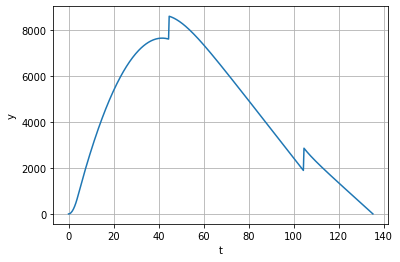

In [58]:
t_range = np.linspace(nominal_sol.t_min(), nominal_sol.t_max(), 500)
plt.plot(t_range, nominal_sol.sol(t_range)[0])
plt.xlabel('t')
plt.ylabel('y')
plt.grid()

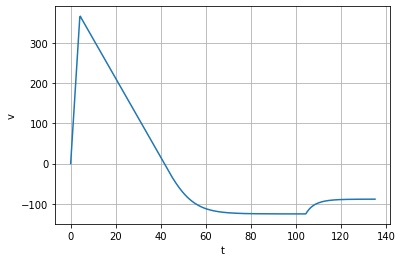

In [59]:
t_range = np.linspace(nominal_sol.t_min(), nominal_sol.t_max(), 500)
plt.plot(t_range, nominal_sol.sol(t_range)[1])
plt.xlabel('t')
plt.ylabel('v')
plt.grid()

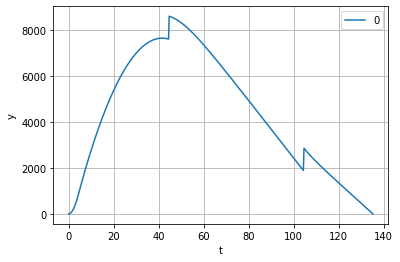

In [60]:
i=0;
t_range = np.linspace(nominal_sol.t_min(),nominal_sol.t_max(), 500)
plt.plot(t_range,nominal_sol.sol(t_range)[0], label=i)

    #plt.xlim([0,50])
plt.grid()
plt.xlabel('t')
plt.ylabel('y')
plt.legend()

In [61]:
full_sol = s.full_solve([0,6000], r.y0, 0)


 Full Simulating: T: [0, 6000], Y0: [0. 0.], Stage: 0
Got:  [array([41.57554744]), array([73.97050835]), array([81.06120925]), array([], dtype=float64)]
For tspan=[0, 6000] and stage=0, About to use i,j = i=0,j=0, next_stage=1 of [1, 2]

 Full Simulating: T: [44.57554744437444, 6000], Y0: [8603.32627891  -29.43      ], Stage: 1
Got:  [array([], dtype=float64), array([99.44060041]), array([119.39785911]), array([], dtype=float64)]
For tspan=[44.57554744437444, 6000] and stage=1, About to use i,j = i=1,j=0, next_stage=2 of [2]

 Full Simulating: T: [104.44060041062723, 6000], Y0: [2873.81934837 -125.28443688], Stage: 2
Got:  [array([], dtype=float64), array([107.7384844]), array([135.1767903]), array([], dtype=float64)]
For tspan=[0, 6000] and stage=0, About to use i,j = i=0,j=0, next_stage=2 of [1, 2]

 Full Simulating: T: [44.57554744437444, 6000], Y0: [8603.32627891  -29.43      ], Stage: 2
Got:  [array([], dtype=float64), array([117.13802199]), array([145.35566564]), array([], dtype

In [62]:
full_sol

[
  [
  Stages: [0]
  Sols: [  message: 'A termination event occurred.'
      nfev: 98
      njev: 0
       nlu: 0
       sol: <scipy.integrate._ivp.common.OdeSolution object at 0x114e16cc0>
    status: 1
   success: True
         t: array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
        1.11100000e-01, 1.11110000e+00, 2.79214387e+00, 3.62727257e+00,
        4.46240128e+00, 5.31679544e+00, 1.38607371e+01, 8.10612092e+01])
  t_events: [array([41.57554744]), array([73.97050835]), array([81.06120925]), array([], dtype=float64)]
         y: array([[ 0.00000000e+00,  4.50950000e-07,  5.45649500e-05,
          5.55615495e-03,  5.56617055e-01,  5.56717261e+01,
          3.51563658e+02,  5.93319709e+02,  8.91394822e+02,
          1.19888202e+03,  3.87988823e+03,  2.27373675e-12],
        [ 0.00000000e+00,  9.01900000e-03,  9.92090000e-02,
          1.00110900e+00,  1.00201090e+01,  1.00210109e+02,
          2.51823455e+02,  3.27143713e+02,  3.64079964e+02,
          3.5

In [63]:
len(full_sol)

5

In [64]:
type(full_sol[2])

__main__.SolutionBranch

In [65]:
full_sol[0]


 [
 Stages: [0]
 Sols: [  message: 'A termination event occurred.'
     nfev: 98
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x114e16cc0>
   status: 1
  success: True
        t: array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
       1.11100000e-01, 1.11110000e+00, 2.79214387e+00, 3.62727257e+00,
       4.46240128e+00, 5.31679544e+00, 1.38607371e+01, 8.10612092e+01])
 t_events: [array([41.57554744]), array([73.97050835]), array([81.06120925]), array([], dtype=float64)]
        y: array([[ 0.00000000e+00,  4.50950000e-07,  5.45649500e-05,
         5.55615495e-03,  5.56617055e-01,  5.56717261e+01,
         3.51563658e+02,  5.93319709e+02,  8.91394822e+02,
         1.19888202e+03,  3.87988823e+03,  2.27373675e-12],
       [ 0.00000000e+00,  9.01900000e-03,  9.92090000e-02,
         1.00110900e+00,  1.00201090e+01,  1.00210109e+02,
         2.51823455e+02,  3.27143713e+02,  3.64079964e+02,
         3.55698357e+02,  2.718822

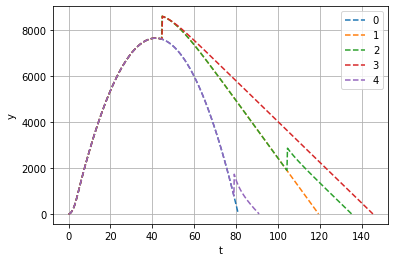

In [66]:
i=0;
for sol in full_sol:
    t_range = np.linspace(sol.t_min(),sol.t_max(), 500)
    plt.plot(t_range,sol.sol(t_range)[0], '--',label=i)
    i+=1
    #plt.xlim([0,50])
    
t_range = np.linspace(nominal_sol.t_min(),nominal_sol.t_max(), 500)
#plt.plot(t_range,nominal_sol.sol(t_range)[0], 'k', label='Nominal')

plt.grid()
plt.xlabel('t')
plt.ylabel('y')
plt.legend()

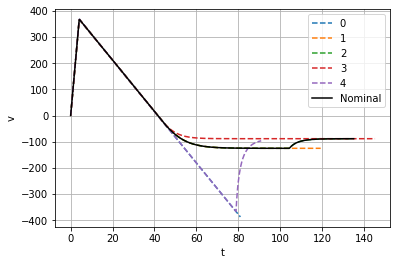

In [67]:
i=0;
for sol in full_sol:
    t_range = np.linspace(sol.t_min(),sol.t_max(), 500)
    plt.plot(t_range,sol.sol(t_range)[1], '--',label=i)
    i+=1
    #plt.xlim([0,50])
    
t_range = np.linspace(nominal_sol.t_min(),nominal_sol.t_max(), 500)
plt.plot(t_range,nominal_sol.sol(t_range)[1], 'k', label='Nominal')

plt.grid()
plt.xlabel('t')
plt.ylabel('v')
plt.legend()

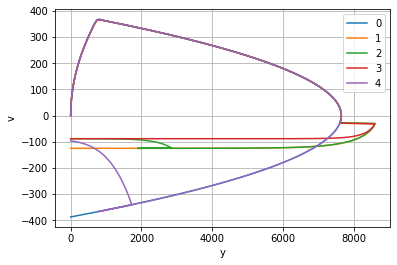

In [68]:
i=0;
for sol in full_sol:
    t_range = np.linspace(sol.t_min(),sol.t_max(), 500)
    plt.plot(sol.sol(t_range)[0],sol.sol(t_range)[1], label=i)
    i+=1
    #plt.xlim([0,50])
plt.grid()
plt.xlabel('y')
plt.ylabel('v')
plt.legend()

In [69]:
len(full_sol)

5

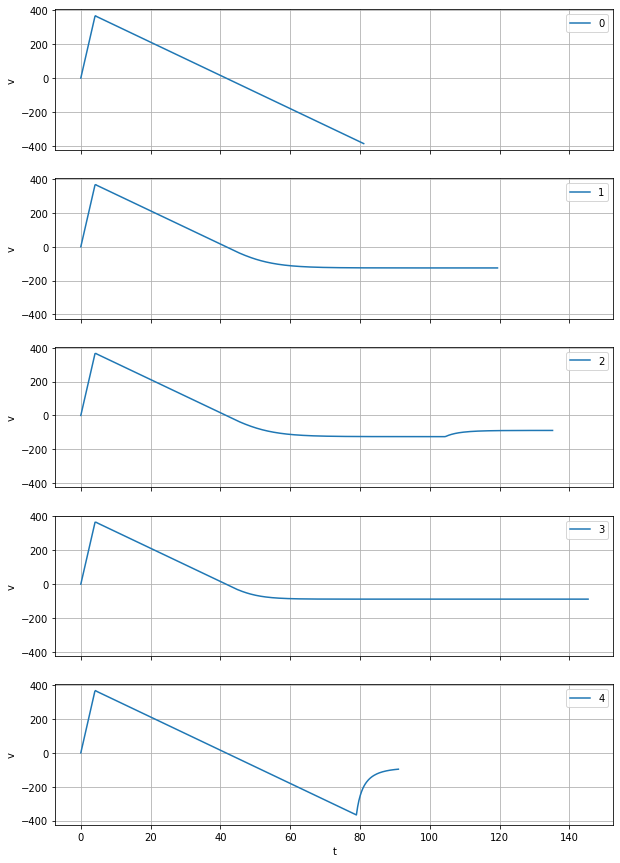

In [70]:
i=0;
fig, axes = plt.subplots(len(full_sol),1, sharex=True, sharey=True, figsize=(10,15), squeeze=True)
for sol in full_sol:
    t_range = np.linspace(sol.t_min(),sol.t_max(), 500)
    axes[i].plot(t_range,sol.sol(t_range)[1], label=i)
    
    #plt.xlim([0,50])
    axes[i].grid(True)
    plt.xlabel('t')
    axes[i].set_ylabel('v')
    axes[i].legend()
    i+=1
